# Project Tasks

In the first few assignments, we have learned how to infer part based components (known as mutational signatures) generated by particular mutational processes using Non-negative Matrix Factorization (NMF). By doing this, we are trying to reconstruct the mutation catalog in a given sample with mutational signatures and their contributions.

In this group project, you will use similar mutational profiles and signature activities to predict cancer types but with much larger sample size. 
You should:
* Separate the data into training and test groups within each cancer type.
* Find out which features are informative for the prediction of the cancer type (label). You should combine the profiles and activities and use each data type independently.
* Implement different models for classification of the samples given the input data and evaluate the model performance using test data to avoid overfitting. Explain briefly how does each model that you have used work.
* Report model performance, using standard machine learning metrics such as confusion matrices etc. 
* Compare model performance across methods and across cancer types, are some types easier top predict than others.
* Submit a single Jupyter notebook as the final report and present that during the last assignment session 

# Data

The data include both mutational catalogs from multiple cancers and the predicted activities in the paper ["Alexandrov LB, et al. (2020) The repertoire of mutational signatures in human cancer"](https://www.nature.com/articles/s41586-020-1943-3). The data either are generated from whole human genome (WGS) or only exomes regions (WES). Since the exome region only constitutes about 1% of human genome, the total mutation numbers in these samples are, of course, much smaller. So if you plan to use WGS together with WES data, remember to normalize the profile for each sample to sum up to 1.

Note that, the data is generated from different platforms by different research groups, some of them (e.g. labeled with PCAWG, TCGA) are processed with the same bioinformatics pipeline. Thus, these samples will have less variability related to data processing pipelines.

Cancer types might be labeled under the same tissue, e.g. 'Bone-Benign','Bone-Epith', which can also be combined together or take the one has more samples.

Here is a link to background reading ["Pan-Cancer Analysis of Whole Genomes"](https://www.nature.com/collections/afdejfafdb). Have a look especially the paper ["A deep learning system accurately classifies primary and metastatic cancers using passenger mutation patterns"](https://www.nature.com/articles/s41467-019-13825-8).

In [411]:
import pandas as pd
import re

## Mutational catalogs and activities - WGS data

In [412]:
## PCAWG data is performed by the same pipeline
PCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_PCAWG.96.csv")
PCAWG_wgs_mut.head(2)

Mutation type Trinucleotide  Biliary-AdenoCA::SP117655  \
0           C>A           ACA                        269   
1           C>A           ACC                        148   

   Biliary-AdenoCA::SP117556  Biliary-AdenoCA::SP117627  \
0                        114                        105   
1                         56                         71   

   Biliary-AdenoCA::SP117775  Biliary-AdenoCA::SP117332  \
0                        217                         52   
1                        123                         36   

   Biliary-AdenoCA::SP117712  Biliary-AdenoCA::SP117017  \
0                        192                         54   
1                        139                         54   

   Biliary-AdenoCA::SP117031  ...  Uterus-AdenoCA::SP94540  \
0                        196  ...                      117   
1                        102  ...                       90   

   Uterus-AdenoCA::SP95222  Uterus-AdenoCA::SP89389  Uterus-AdenoCA::SP90503  \
0                      233                       94                      114   
1                      167                       59                       64   

   Uterus-AdenoCA::SP92460  Uterus-AdenoCA::SP92931  Uterus-AdenoCA::SP91265  \
0                      257                      139                      404   
1                      268                       75                      255   

   Uterus-AdenoCA::SP89909  Uterus-AdenoCA::SP90629  Uterus-AdenoCA::SP95550  
0                       97                      250                      170  
1                       78                      188                      137  

[2 rows x 2782 columns]

Accuracy is the cosine similarity of reconstruct catalog to the observed catalog 

In [413]:
## Activities:
PCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_PCAWG.activities.csv")
PCAWG_wgs_act.head(2)

Cancer Types Sample Names  Accuracy  SBS1  SBS2  SBS3  SBS4  SBS5  SBS6  \
0  Biliary-AdenoCA     SP117655     0.968  1496  1296     0     0  1825     0   
1  Biliary-AdenoCA     SP117556     0.963   985     0     0     0   922     0   

   SBS7a  ...  SBS51  SBS52  SBS53  SBS54  SBS55  SBS56  SBS57  SBS58  SBS59  \
0      0  ...      0      0      0      0      0      0      0      0      0   
1      0  ...      0      0      0      0      0      0      0      0      0   

   SBS60  
0      0  
1      0  

[2 rows x 68 columns]

In [414]:
nonPCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_Other.96.csv")
nonPCAWG_wgs_mut.head(2)

Mutation type Trinucleotide  ALL::PD4020a  ALL::SJBALL011_D  \
0           C>A           ACA            35                 9   
1           C>A           ACC            16                 2   

   ALL::SJBALL012_D  ALL::SJBALL020013_D1  ALL::SJBALL020422_D1  \
0                 2                     7                     5   
1                 4                    10                     5   

   ALL::SJBALL020579_D1  ALL::SJBALL020589_D1  ALL::SJBALL020625_D1  ...  \
0                     7                     3                     5  ...   
1                     9                     1                     2  ...   

   Stomach-AdenoCa::pfg316T  Stomach-AdenoCa::pfg317T  \
0                       133                       185   
1                        48                        70   

   Stomach-AdenoCa::pfg344T  Stomach-AdenoCa::pfg373T  \
0                       202                       185   
1                       126                        88   

   Stomach-AdenoCa::pfg375T  Stomach-AdenoCa::pfg378T  \
0                        96                       134   
1                        35                        54   

   Stomach-AdenoCa::pfg398T  Stomach-AdenoCa::pfg413T  \
0                        12                       279   
1                        16                       112   

   Stomach-AdenoCa::pfg416T  Stomach-AdenoCa::pfg424T  
0                        75                       135  
1                        31                        91  

[2 rows x 1867 columns]

In [415]:
nonPCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_Other.activities.csv")
nonPCAWG_wgs_act.head(2)

Cancer Types Sample Names  Accuracy  SBS1  SBS2  SBS3  SBS4  SBS5  SBS6  \
0          ALL      PD4020a     0.995   208  3006     0     0   365     0   
1          ALL  SJBALL011_D     0.905    66     0     0     0   144     0   

   SBS7a  ...  SBS51  SBS52  SBS53  SBS54  SBS55  SBS56  SBS57  SBS58  SBS59  \
0      0  ...      0      0      0      0      0      0      0      0      0   
1      0  ...      0      0      0      0      0      0      0      0      0   

   SBS60  
0      0  
1      0  

[2 rows x 68 columns]

## Mutational catalogs - WES data

In [416]:
## Performed by TCGA pipeline
TCGA_wes_mut = pd.read_csv ("./project_data/catalogs/WES/WES_TCGA.96.csv")
TCGA_wes_mut.head(2)

Mutation type Trinucleotide  AML::TCGA-AB-2802-03B-01W-0728-08  \
0           C>A           ACA                                  0   
1           C>A           ACC                                  0   

   AML::TCGA-AB-2803-03B-01W-0728-08  AML::TCGA-AB-2804-03B-01W-0728-08  \
0                                  0                                  0   
1                                  2                                  0   

   AML::TCGA-AB-2805-03B-01W-0728-08  AML::TCGA-AB-2806-03B-01W-0728-08  \
0                                  0                                  4   
1                                  0                                  0   

   AML::TCGA-AB-2807-03B-01W-0728-08  AML::TCGA-AB-2808-03B-01W-0728-08  \
0                                  0                                  2   
1                                  1                                  3   

   AML::TCGA-AB-2809-03D-01W-0755-09  ...  \
0                                  0  ...   
1                                  0  ...   

   Eye-Melanoma::TCGA-WC-A885-01A-11D-A39W-08  \
0                                           1   
1                                           0   

   Eye-Melanoma::TCGA-WC-A888-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-WC-A88A-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-WC-AA9A-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-WC-AA9E-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-YZ-A980-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-YZ-A982-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-YZ-A983-01A-11D-A39W-08  \
0                                           0   
1                                           1   

   Eye-Melanoma::TCGA-YZ-A984-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-YZ-A985-01A-11D-A39W-08  
0                                           0  
1                                           0  

[2 rows x 9495 columns]

In [417]:
##Activities
TCGA_wes_act = pd.read_csv("./project_data/activities/WES/WES_TCGA.activities.csv")
TCGA_wes_act.head(2)

Cancer Types                  Sample Names  Accuracy  SBS1  SBS2  SBS3  \
0          AML  TCGA-AB-2802-03B-01W-0728-08     0.811     3     0     0   
1          AML  TCGA-AB-2803-03B-01W-0728-08     0.608     4     0     0   

   SBS4  SBS5  SBS6  SBS7a  ...  SBS51  SBS52  SBS53  SBS54  SBS55  SBS56  \
0     0     0     0      0  ...      0      0      0      0      0      0   
1     0     7     0      0  ...      0      0      0      0      0      0   

   SBS57  SBS58  SBS59  SBS60  
0      0      0      0      0  
1      0      0      0      0  

[2 rows x 68 columns]

In [418]:
other_wes_mut = pd.read_csv("./project_data/catalogs/WES/WES_Other.96.csv")
other_wes_mut.head(2)

Mutation type Trinucleotide  ALL::TARGET-10-PAIXPH-03A-01D  \
0           C>A           ACA                              0   
1           C>A           ACC                              0   

   ALL::TARGET-10-PAKHZT-03A-01R  ALL::TARGET-10-PAKMVD-09A-01D  \
0                              0                              0   
1                              0                              0   

   ALL::TARGET-10-PAKSWW-03A-01D  ALL::TARGET-10-PALETF-03A-01D  \
0                              1                              0   
1                              1                              0   

   ALL::TARGET-10-PALLSD-09A-01D  ALL::TARGET-10-PAMDKS-03A-01D  \
0                              0                              0   
1                              0                              0   

   ALL::TARGET-10-PAPJIB-04A-01D  ...  Head-SCC::V-109  Head-SCC::V-112  \
0                              2  ...                0                0   
1                              0  ...                1                0   

   Head-SCC::V-116  Head-SCC::V-119  Head-SCC::V-123  Head-SCC::V-124  \
0                0                0                0                0   
1                0                0                0                0   

   Head-SCC::V-125  Head-SCC::V-14  Head-SCC::V-29  Head-SCC::V-98  
0                0               0               0               1  
1                0               1               0               0  

[2 rows x 9693 columns]

In [419]:
other_wes_act = pd.read_csv("./project_data/activities/WES/WES_Other.activities.csv")
other_wes_act.head(2)

Cancer Types              Sample Names  Accuracy  SBS1  SBS2  SBS3  SBS4  \
0          ALL  TARGET-10-PAIXPH-03A-01D     0.529     0     0     0     0   
1          ALL  TARGET-10-PAKHZT-03A-01R     0.696     0     0     0     0   

   SBS5  SBS6  SBS7a  ...  SBS51  SBS52  SBS53  SBS54  SBS55  SBS56  SBS57  \
0     0     0      0  ...      0      0      0      1      0      0      0   
1     0     0      0  ...      0      0      0      1      0      0      0   

   SBS58  SBS59  SBS60  
0      0      0      0  
1      0      0      0  

[2 rows x 68 columns]

### Imports and helpers

In [420]:
import re
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
#import torch 

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder

# These ones are work in progress
def plot_roc_auc(X_tst, y_test, model, is_multi_class=False):
    probs = model.predict_proba(X_tst)
    probs = probs[:, 1]
    if is_multi_class:
        auc = roc_auc_score(y_test, probs, multi_class='ovo')
    else:
        auc = roc_auc_score(y_test, probs, multi_class='ovo')
    
    fp_rate, tp_rate, thresholds = roc_curve(y_test, probs)
    
    plt.figure(figsize=(7,6))
    plt.axis('scaled')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title("AUC & ROC")
    plt.plot(fp_rate, tp_rate, 'g')
    plt.fill_between(fp_rate, tp_rate, facecolor = "green", alpha = 0.7)
    plt.text(0.95, 0.05, f'AUC = {auc}', ha='right', fontsize=12, weight='bold', color='blue')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

def plot_confusion_mat(y_test, y_pred, labs=None, size=None):
    cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
    if size is None:
        plt.figure(figsize=(12,10))
    else:
        plt.figure(figsize=size)
    if labs is None:
        sns.heatmap(cm, square=False, annot=True, fmt='d', cmap='viridis', cbar=True)
    else:
        sns.heatmap(cm, square=False, annot=True, fmt='d', cmap='viridis', xticklabels=labs, yticklabels=labs, cbar=True)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    #plt.ylim(0, 2)

def plot_learning_curve(model, X, y):
    N, train_lc, val_lc = learning_curve(model, X, y, cv=7, train_sizes=np.linspace(0.3, 1, 25))
    plt.figure(figsize=(7,6))
    plt.title("Learning curve")
    plt.plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    plt.plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    #plt.hlines(N, np.mean([train_lc[-1],  val_lc[-1]]), N[0], N[-1], color='gray', label='mean', linestyle='dashed')

def plot_trn_tst_dist(y_all, y_train, y_test, y_pred, in_cols=False):
    #fig = None
    #ax = None
    if in_cols:
        fig, ax = plt.subplots(2,2)
    else:
        fig, ax = plt.subplots(4,1)

    fig.set_size_inches(15,8)

    plt_sets = [y_all, y_train, y_test, y_pred]
    plt_labels = ["All", "Train", "Test", "Pred"]
    plt_set_df = pd.DataFrame()
    for i in range(len(plt_sets)):
        s = pd.Series(plt_sets[i]).value_counts().sort_index()
        plt_set_df[plt_labels[i]] = s
    
        pd.DataFrame({plt_labels[i]: s}).plot(ax=ax.flat[i], kind="bar")
        #sns.countplot(x=s, 
        #            palette=sns.hls_palette(2),
        #            ax=ax[i])
        ax.flat[i].tick_params(axis="x", rotation=90)

    fig.tight_layout()
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 2,
                       ):
        print(plt_set_df)


   


### Dataset preprocess, combine profile data to a single data frame

From all profile sets, a combined data frame is made, which has samples in the rows and features in the columns.

In [421]:

def prepare_mut_df(raw_mutation_dfs, is_profile, small_sample_limit=None):

    mutations_all = pd.DataFrame()

    for df in raw_mutation_dfs:
        # Make a copy of the original data frame and start processing from there
        mutations  = df.copy()
    
        if is_profile:
            mutations['mut_tri'] = mutations.apply(lambda a: '{}_{}'.format(a['Mutation type'], a['Trinucleotide']), axis=1)
            mutations = mutations.set_index('mut_tri').drop(['Mutation type', 'Trinucleotide'], axis=1)
            mutations = mutations.T
        else:
            mutations['mut_tri'] = mutations.apply(lambda a: '{}::{}'.format(a['Cancer Types'], a['Sample Names']), axis=1)
            mutations = mutations.set_index('mut_tri').drop(['Cancer Types', 'Sample Names', 'Accuracy'], axis=1)
     
        # Rename some index names
        renamed_items = list(mutations.index)
        index_items = list(mutations.index)

        # Combine rows for low count labels
        for i in range(len(index_items)):
            result = index_items[i]
            parts = result.split('-')
            if len(parts) > 1:
                result = parts[1]
            else:
                result = parts[0]
            
            #result = result.split('-')[0]
            #for to_sub in ['Adeno', 'Bone', 'Breast', 'Cervix', 'CNS', 'Eye', 'Liver', 'Lymph', 'Lung', 'Kidney', 'Myeloid', 'Panc' ]:
            #    result = re.sub( to_sub + r'(-\w*)', to_sub, result)
                
            renamed_items[i] = result.replace('Ca', 'CA')
       
        mutations.rename(index=dict(zip(index_items, renamed_items)), inplace = True)
   
        # Normalize 
        row_sums = mutations.sum(axis=1)
        mutations = mutations.divide(row_sums, axis = 0)

        mutations_all = pd.concat([mutations_all, mutations])

    mutations_all.sort_index(inplace=True)

    # Do we need to renormalize after obtaining the full dataframe?
  
    # Figure out tumor types based on the first part of the index
    tumor_types = [a.split(':')[0] for a in mutations_all.index]
    
    #print("ttt", tumor_types)
    mutations_all["tumor_types"] = tumor_types

    # Get rid of types with very few samples if the limit is specified
    if small_sample_limit is not None:
        mutations_all = cull_small_sample_counts(mutations_all, small_sample_limit)

    tumor_types = mutations_all["tumor_types"] 

    # Prepare a list with all the types appearing only once
    unique_tumor_types = sorted(list(set(tumor_types)))
    # Attach this back to the frame
    
    return (mutations_all, unique_tumor_types)

def cull_small_sample_counts(mutations, small_sample_limit):
    
    counts = mutations["tumor_types"].value_counts()
    big_counts = counts[list(counts > small_sample_limit)]
    big_index = mutations["tumor_types"].isin(list(big_counts.index))
    mutations = mutations[big_index]

    return mutations

def print_dset_diag(mut_df, unique_tumor_types, small_sample_limit):
    # Check if the data frame is ok
    print("\n---Data set diagnostics print---\n")
    print("Missing entries in mutations:", mut_df.isnull().sum().sum())
    print("The shape of the mutations data frame", mut_df.shape)

    # Check to see if the rows are normalized to one, take a sample from the data frame
    norm_df = mut_df.sample(n=5, random_state=5)
    print("Checking normalization: sum of some rows:\n", norm_df.iloc[:,0:-1].sum(axis=1))
    print("\n")

    # Check some counts of tumor types
    tumor_counts = mut_df["tumor_types"].value_counts() #.sort_values(ascending=True)
    print("Tumor counts:\n", tumor_counts)
    print("\n")

    small_counts = tumor_counts < 1.5*small_sample_limit
    print("Tumor types with smallish counts:",  sum(small_counts))

    print(tumor_counts[small_counts])
    print("\n")

    # Tumor types
    print("Unique tumor types: ", len(unique_tumor_types))
    print(unique_tumor_types)


small_sample_limit = 250

profile_raw_data_sets = [PCAWG_wgs_mut, TCGA_wes_mut, nonPCAWG_wgs_mut, other_wes_mut]
profile_mut_all, prf_unique_tumor_types = prepare_mut_df(profile_raw_data_sets, True, small_sample_limit)

# Print some diagnostics from the prepared data set
print("Profile data:")
print_dset_diag(profile_mut_all, prf_unique_tumor_types, small_sample_limit)

# Data matrix X for fitting, omit the tumor labeling from there, use that information in constructing true y
# Note: this contains profile data only
#X_prf = profile_mut_all.drop("tumor_types", axis=1)

Profile data:

---Data set diagnostics print---

Missing entries in mutations: 0
The shape of the mutations data frame (20343, 97)
Checking normalization: sum of some rows:
 cancer::TK74_LCIS2    1.0
RCC::TCGA             1.0
AdenoCA::TCGA         1.0
AdenoCA::TCGA         1.0
Melanoma::TCGA        1.0
dtype: float64


Tumor counts:
 AdenoCA      7712
SCC          2188
cancer       1639
HCC          1318
Melanoma     1231
BNHL          822
RCC           775
GBM           605
Medullo       557
CA            462
cell          389
CMDI          357
LGG           326
CLL           302
Papillary     297
neoplasm      247
ALL           240
Ewings        231
AML           230
30            212
bone          203
Name: tumor_types, dtype: int64


Tumor types with smallish counts: 7
Papillary    297
neoplasm     247
ALL          240
Ewings       231
AML          230
30           212
bone         203
Name: tumor_types, dtype: int64


Unique tumor types:  21
['30', 'ALL', 'AML', 'AdenoCA', 'BNHL',

### Dataset preprocess for activites data

In [422]:
act_raw_data_sets = [PCAWG_wgs_act, TCGA_wes_act, nonPCAWG_wgs_act, other_wes_act]
act_mut_all, act_unique_tumor_types = prepare_mut_df(act_raw_data_sets, is_profile=False, small_sample_limit=small_sample_limit)

# Print some diagnostics from the prepared data set
print("Activities data:")
print_dset_diag(act_mut_all, act_unique_tumor_types, small_sample_limit)

# Data matrix X for fitting, omit the tumor labeling from there, use that information in constructing true y
# Note: this contains profile data only
X_act = act_mut_all.drop("tumor_types", axis=1)

Activities data:

---Data set diagnostics print---

Missing entries in mutations: 0
The shape of the mutations data frame (20343, 66)
Checking normalization: sum of some rows:
 mut_tri
cancer::TK74_LCIS2    1.0
RCC::TCGA             1.0
AdenoCA::TCGA         1.0
AdenoCA::TCGA         1.0
Melanoma::TCGA        1.0
dtype: float64


Tumor counts:
 AdenoCA      7712
SCC          2188
cancer       1639
HCC          1318
Melanoma     1231
BNHL          822
RCC           775
GBM           605
Medullo       557
CA            462
cell          389
CMDI          357
LGG           326
CLL           302
Papillary     297
neoplasm      247
ALL           240
Ewings        231
AML           230
30            212
bone          203
Name: tumor_types, dtype: int64


Tumor types with smallish counts: 7
Papillary    297
neoplasm     247
ALL          240
Ewings       231
AML          230
30           212
bone         203
Name: tumor_types, dtype: int64


Unique tumor types:  21
['30', 'ALL', 'AML', 'AdenoC

### Check profile data content

In [423]:
print("Some content from the full profile set:")
profile_mut_all.head(5)

Some content from the full profile set:


mut_tri   C>A_ACA   C>A_ACC   C>A_ACG  C>A_ACT  C>A_CCA   C>A_CCC   C>A_CCG  \
30       0.000000  0.000000  0.000000     0.00     0.00  0.000000  0.000000   
30       0.040000  0.000000  0.000000     0.02     0.08  0.020000  0.020000   
30       0.153846  0.000000  0.000000     0.00     0.00  0.076923  0.000000   
30       0.000000  0.032258  0.032258     0.00     0.00  0.000000  0.032258   
30       0.100000  0.100000  0.000000     0.00     0.00  0.000000  0.000000   

mut_tri   C>A_CCT   C>A_GCA   C>A_GCC  ...  T>G_CTT  T>G_GTA  T>G_GTC  \
30       0.100000  0.100000  0.000000  ...     0.00      0.0      0.0   
30       0.040000  0.140000  0.000000  ...     0.04      0.0      0.0   
30       0.076923  0.076923  0.000000  ...     0.00      0.0      0.0   
30       0.032258  0.032258  0.032258  ...     0.00      0.0      0.0   
30       0.000000  0.000000  0.000000  ...     0.00      0.0      0.0   

mut_tri  T>G_GTG  T>G_GTT  T>G_TTA  T>G_TTC  T>G_TTG  T>G_TTT  tumor_types  
30           0.1      0.0      0.0      0.0     0.00      0.0           30  
30           0.0      0.0      0.0      0.0     0.02      0.0           30  
30           0.0      0.0      0.0      0.0     0.00      0.0           30  
30           0.0      0.0      0.0      0.0     0.00      0.0           30  
30           0.0      0.0      0.0      0.0     0.00      0.0           30  

[5 rows x 97 columns]

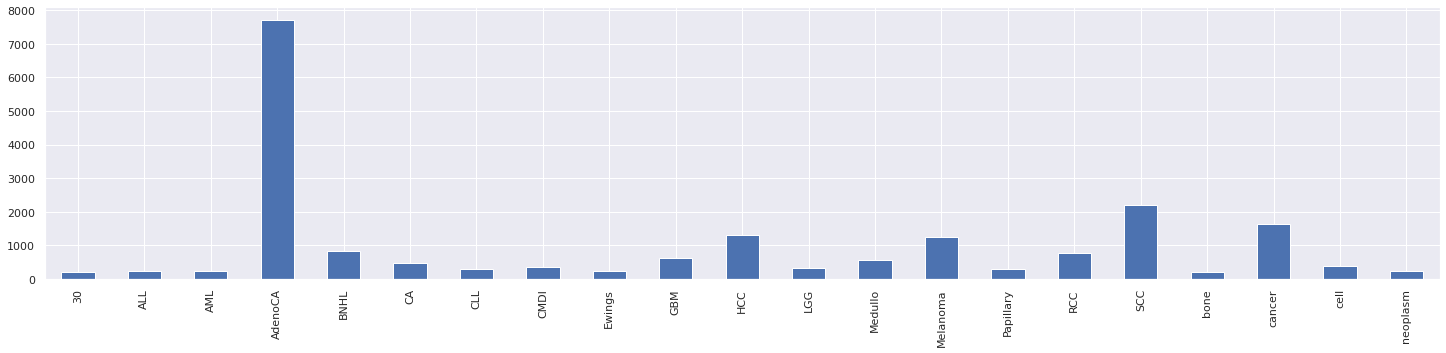

In [424]:
plt.figure(figsize=(25, 5))
sns.set_theme()
profile_mut_all["tumor_types"].value_counts().sort_index().plot(kind="bar")
#sns.countplot(x=profile_mut_all["tumor_types"], palette=sns.hls_palette(2))
plt.xticks(rotation=90);


### Check activites data content

In [425]:
print("Some content from the full act set:")
act_mut_all.head(5)

Some content from the full act set:


SBS1  SBS2  SBS3  SBS4  SBS5  SBS6  SBS7a  SBS7b  SBS7c  SBS7d  ...  \
mut_tri                                                                  ...   
30        0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0  ...   
30        0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0  ...   
30        0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0  ...   
30        0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0  ...   
30        0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0  ...   

         SBS52  SBS53  SBS54  SBS55  SBS56  SBS57  SBS58  SBS59  SBS60  \
mut_tri                                                                  
30         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
30         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
30         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
30         1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
30         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

         tumor_types  
mut_tri               
30                30  
30                30  
30                30  
30                30  
30                30  

[5 rows x 66 columns]

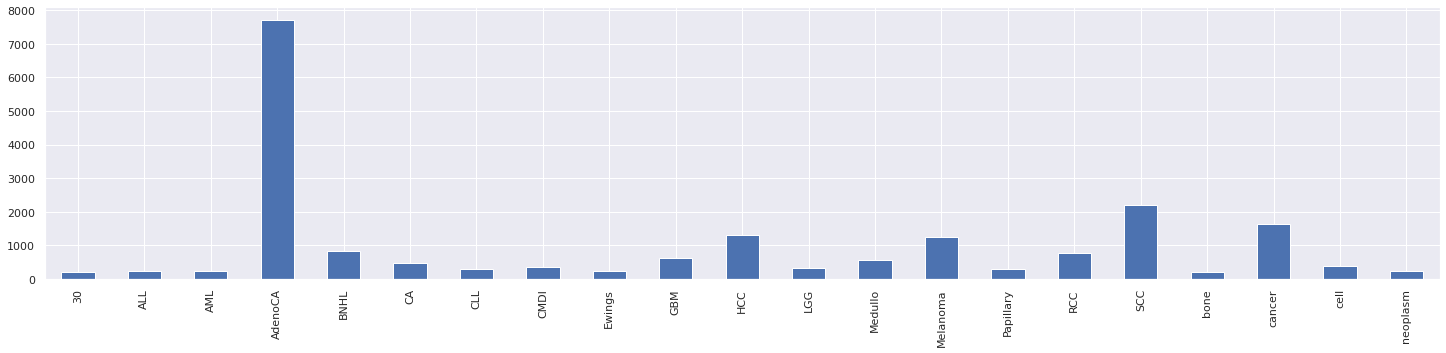

In [426]:
plt.figure(figsize=(25, 5))
sns.set_theme()
act_mut_all["tumor_types"].value_counts().sort_index().plot(kind="bar")
#sns.countplot(x=profile_mut_all["tumor_types"], palette=sns.hls_palette(2))
plt.xticks(rotation=90);


### Multinomial Naive Bayes classifier

AdenoCA      7712
SCC          2188
cancer       1639
HCC          1318
Melanoma     1231
BNHL          822
RCC           775
GBM           605
Medullo       557
CA            462
cell          389
CMDI          357
LGG           326
CLL           302
Papillary     297
neoplasm      247
ALL           240
Ewings        231
AML           230
30            212
bone          203
Name: tumor_types, dtype: int64
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.00      0.00      0.00        41
           2       0.00      0.00      0.00        59
           3       0.38      1.00      0.55      1532
           4       0.00      0.00      0.00       149
           5       0.00      0.00      0.00        91
           6       0.00      0.00      0.00        69
           7       0.00      0.00      0.00        75
           8       0.00      0.00      0.00        45
           9       0.00      0.00      0.00      

/home/jr/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jr/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jr/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     All  Train  Test    Pred
0    212    164    48     NaN
1    240    199    41     NaN
2    230    171    59     NaN
3   7712   6180  1532  4063.0
4    822    673   149     NaN
5    462    371    91     NaN
6    302    233    69     NaN
7    357    282    75     NaN
8    231    186    45     NaN
9    605    491   114     NaN
10  1318   1046   272     NaN
11   326    258    68     NaN
12   557    446   111     NaN
13  1231    989   242     6.0
14   297    236    61     NaN
15   775    626   149     NaN
16  2188   1728   460     NaN
17   203    164    39     NaN
18  1639   1324   315     NaN
19   389    313    76     NaN
20   247    194    53     NaN


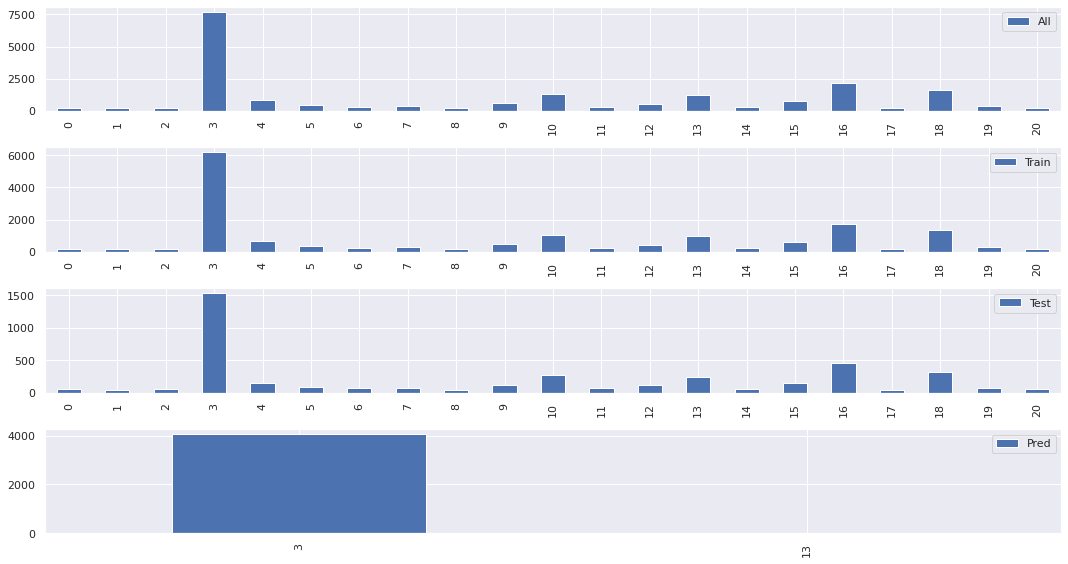

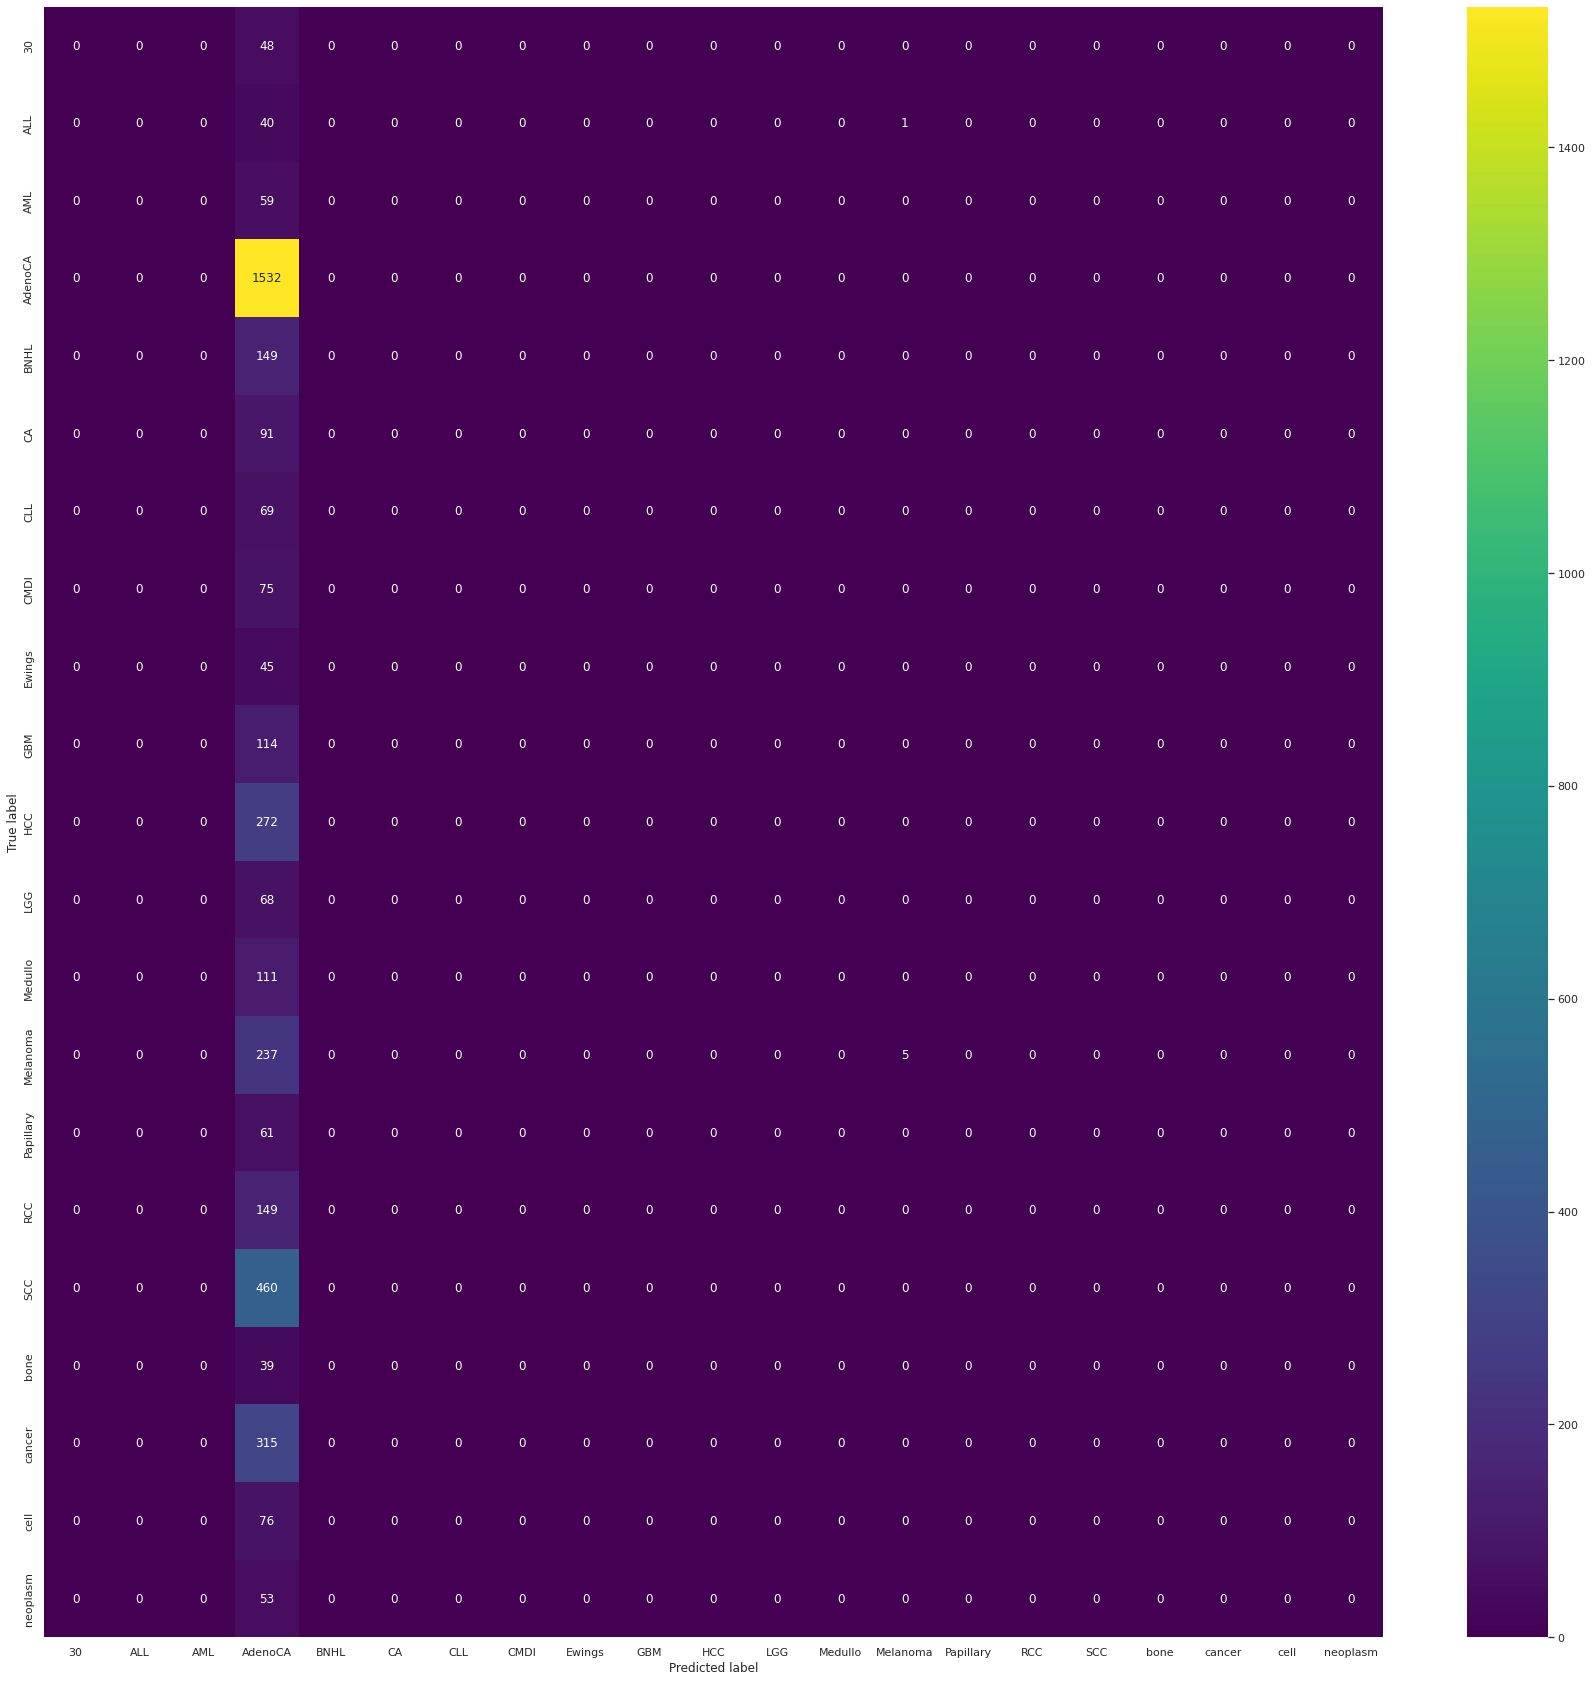

In [427]:
from sklearn.naive_bayes import MultinomialNB
from collections import Counter


X_prf = profile_mut_all.copy()
#idx = X_prf[X_prf["tumor_types"] == "AdenoCA"].index.values
#down_fix_list = ["Breast-cancer", "Liver-HCC", "ColoRect-AdenoCA", "Prost-AdenoCA"]
#down_fix_list = ["AdenoCA"]
#for name in down_fix_list:
#    idx = X_prf[X_prf["tumor_types"] == name].index.values
#    n_idx = len(idx)
#    idx = np.random.choice(idx, n_idx-1000, replace= False)
#    X_prf = X_prf.loc[X_prf.index.difference(idx)]

print(X_prf["tumor_types"].value_counts())
label_encoder = LabelEncoder()

y_prf = X_prf["tumor_types"].values
y_prfm = label_encoder.fit_transform(y_prf)

X_prf.drop("tumor_types", axis=1, inplace=True)

integer_mapping = {l: i for i, l in enumerate(label_encoder.classes_)}
labs = list(integer_mapping.keys())

X_prfm_train, X_prfm_test, y_prfm_train, y_prfm_test = train_test_split(X_prf, y_prfm, test_size = 0.2)

model_nbm = MultinomialNB()
model_nbm.fit(X_prfm_train, y_prfm_train)

y_prfm_pred = model_nbm.predict(X_prfm_test)

print(classification_report(y_prfm_test, y_prfm_pred))

plot_trn_tst_dist(y_prfm, y_prfm_train, y_prfm_test, y_prfm_pred, in_cols=False)
plot_confusion_mat(y_prfm_test, y_prfm_pred, labs=labs, size=(30, 30))


That didn't go very well.

### XGBoost

In [428]:
# You need to install imbalanced-learn for the following cells to work.
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install xgboost

[19:00:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.53      0.38      0.44        48
           1       0.10      0.05      0.07        41
           2       0.64      0.27      0.38        59
           3       0.61      0.85      0.71      1532
           4       0.36      0.33      0.35       149
           5       0.32      0.18      0.23        91
           6       0.87      0.57      0.68        69
           7       0.53      0.53      0.53        75
           8       0.00      0.00      0.00        45
           9       0.57      0.27      0.37       114
          10       0.75      0.68      0.71       272
          11       0.13      0.10      0.11        68
          12       0.33      0.26      0.29 

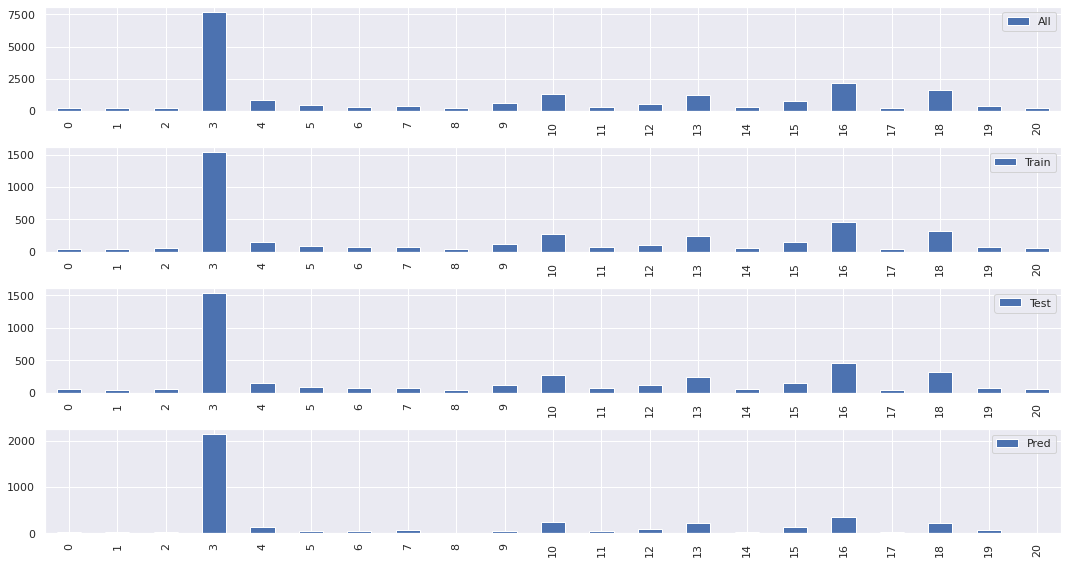

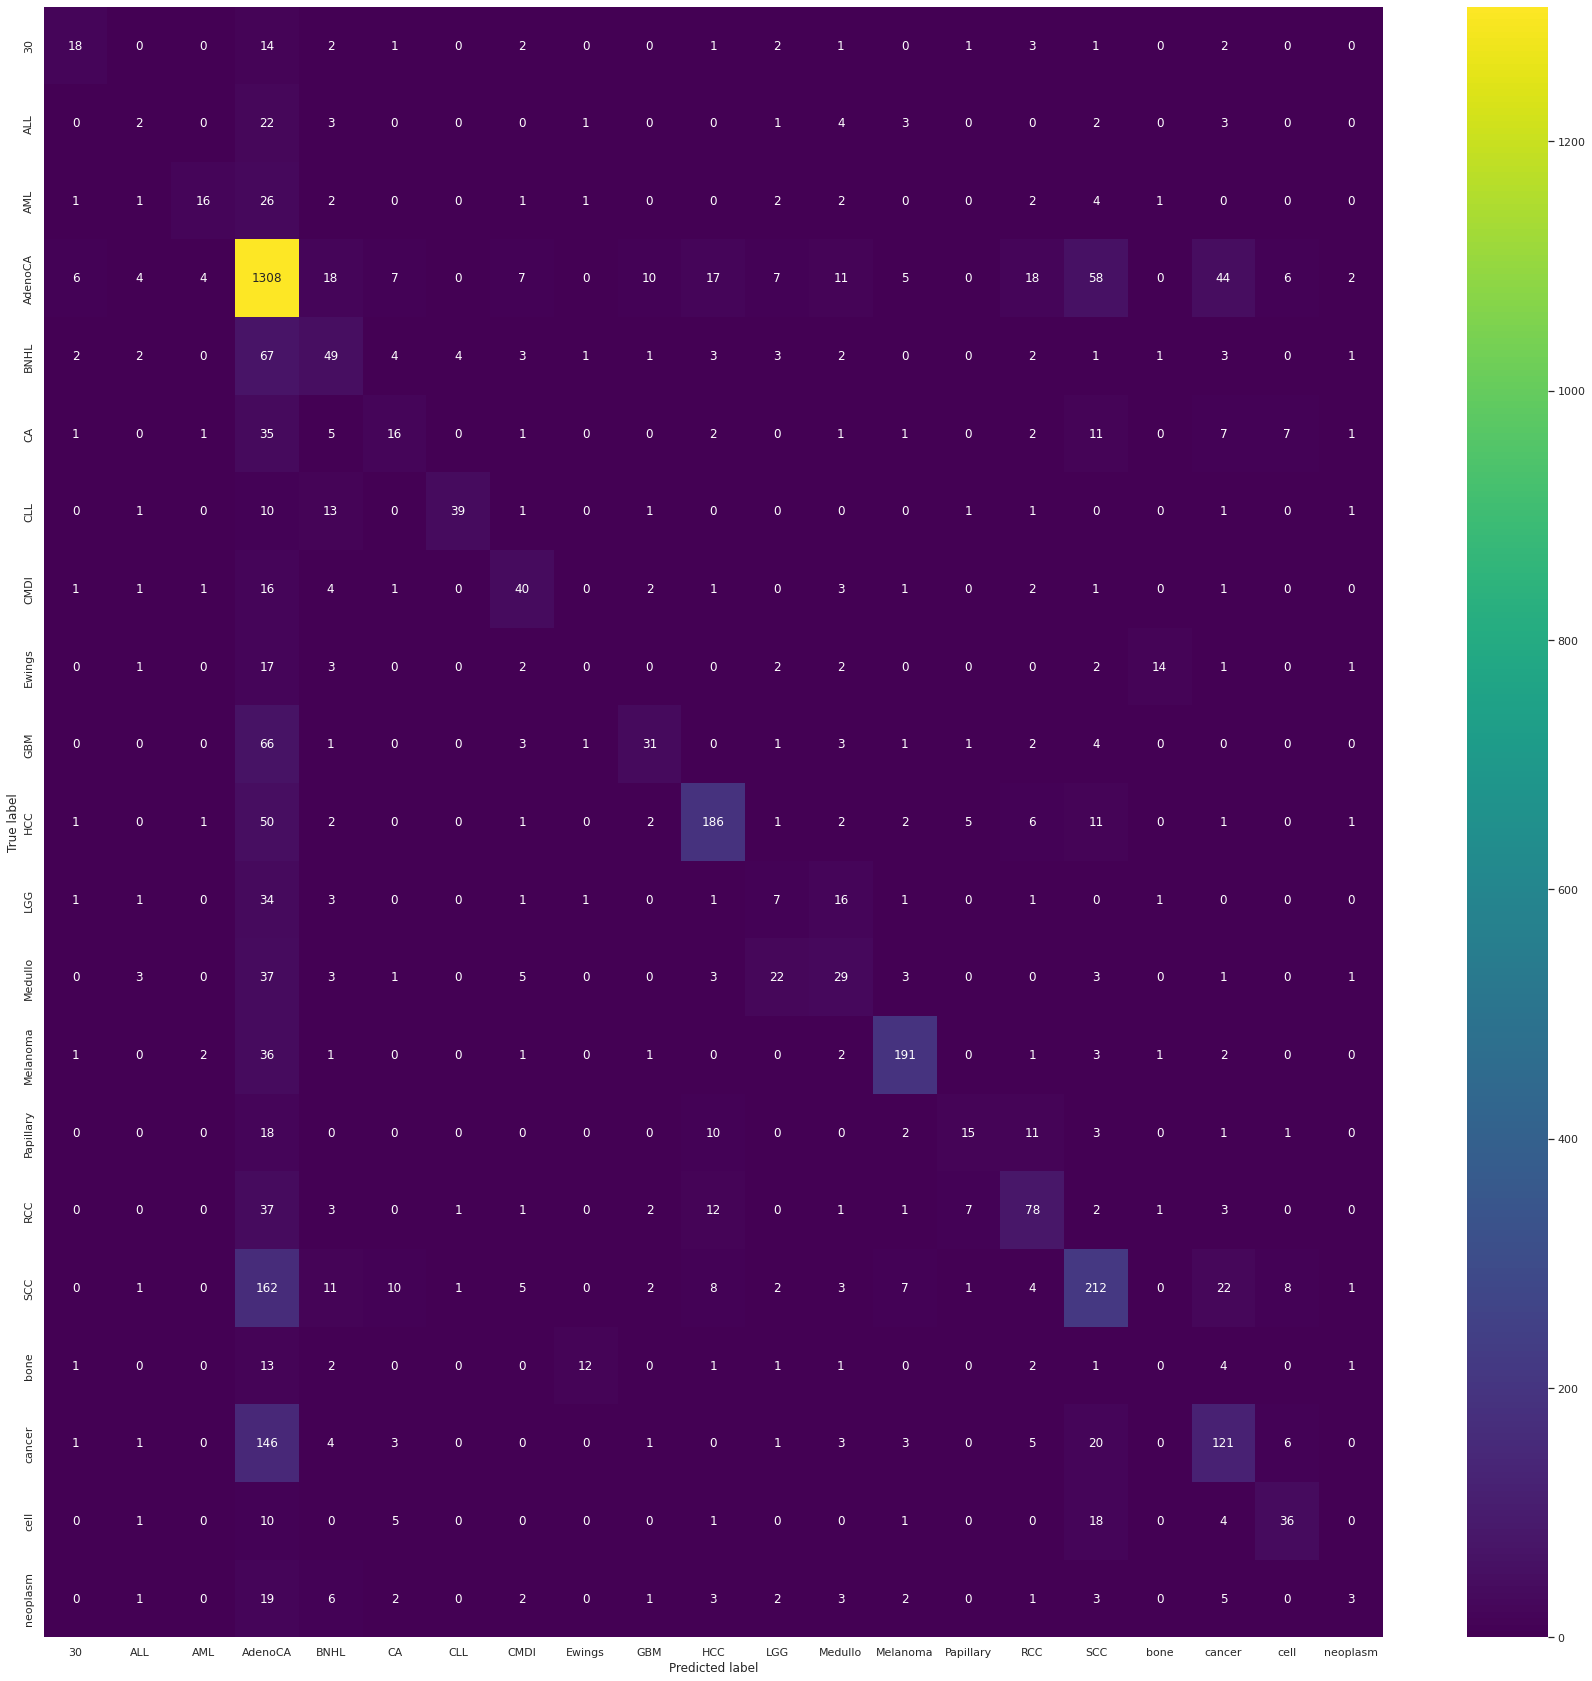

In [429]:
from xgboost import XGBClassifier

model_mxgb = XGBClassifier(n_estimators=200, max_depth=32, use_label_encoder=False)
model_mxgb.fit(X_prfm_train, y_prfm_train)
y_prfm_pred = model_mxgb.predict(X_prfm_test)

#model_nbm.fit(X_prfm_train, y_prfm_train)
#y_prfm_pred = model_nbm.predict(X_prfm_test)

print(classification_report(y_prfm_test, y_prfm_pred))

plot_trn_tst_dist(y_prfm, y_prfm_test, y_prfm_test, y_prfm_pred, in_cols=False)
plot_confusion_mat(y_prfm_test, y_prfm_pred, labs=labs, size=(30, 30))


That went better.